In [2]:
import os
import numpy as np
import librosa
import yaml
import matplotlib.pyplot as plt

# Define instrument mapping
INSTRUMENT_MAPPING = {
    "Piano": 0,
    "Guitar": 1,
    "Bass": 2,
    "Strings": 3,
    "Strings (continued)": 3,
    "Drums": 4
}

# Paths
DATASET_PATH = "slakh2100_flac_redux/reduced_isolated/"
TIMESTAMPS_FILE = "timestamps_isolated.txt"
OUTPUT_DIR = "labels_isolated/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Define program numbers to exclude
EXCLUDED_PROGRAMS = {
    6, 7,  # Harpsichord, Clavinet (Piano)
    46, 47,  # Orchestral Harp, Timpani (Strings)
    52, 53, 54, 55,  # Choir Aahs, Voice Oohs, Synth Voice, Orchestra Hit (Strings continued)
    69, 70,  # English Horn, Bassoon (Reed)
    76, 77, 78, 79  # Blown Bottle, Shakuhachi, Whistle, Ocarina (Pipe)
}

# Step 1: Build stem-to-class mapping (with exclusions)
stem_to_class = {}

for track in sorted(os.listdir(DATASET_PATH)):
    track_path = os.path.join(DATASET_PATH, track)
    metadata_file = os.path.join(track_path, "metadata.yaml")

    if os.path.isdir(track_path) and os.path.exists(metadata_file):
        with open(metadata_file, "r") as f:
            metadata = yaml.safe_load(f)

        if "stems" in metadata:
            for stem, info in metadata["stems"].items():
                inst_class = info.get("inst_class")
                program_num = info.get("program_num")

                # Skip stems with excluded program numbers
                if program_num in EXCLUDED_PROGRAMS:
                    continue

                if inst_class in INSTRUMENT_MAPPING:
                    stem_to_class[f"{track}/{stem}.flac"] = INSTRUMENT_MAPPING[inst_class]

# Step 2: Process timestamps_train.txt
with open(TIMESTAMPS_FILE, "r") as f:
    lines = f.readlines()

current_track = None
activity_matrices = {}

for line in lines:
    line = line.strip()

    if line.startswith("Track: "):
        # Extract track name
        track_path = line.split("Track: ")[1].replace("\\", "/")
        track_name = track_path.split("/")[-1]
        mix_file = os.path.join(track_path, "mix.flac")
        
        # Get track duration
        if os.path.exists(mix_file):
            track_duration = librosa.get_duration(path=mix_file)
            num_columns = int(np.floor(track_duration / 0.5)) 
        else:
            continue  # Skip if mix.flac is missing

        # Initialize binary matrix
        activity_matrices[track_name] = np.zeros((5, num_columns), dtype=np.uint8)
        current_track = track_name

    elif current_track and ".flac:" in line:
        # Extract stem file and timestamps
        parts = line.split(": ")
        stem_file = parts[0]
        timestamps = eval(parts[1])  # Convert string to list of tuples
        
        # Get instrument class for this stem
        stem_key = f"{current_track}/{stem_file}"
        if stem_key in stem_to_class:
            class_index = stem_to_class[stem_key]
            
            # Mark active timeframes
            for start, end in timestamps:
                start_idx = int(np.floor(start / 0.5))
                end_idx = int(np.ceil(end / 0.5))
                activity_matrices[current_track][class_index, start_idx:end_idx] = 1

# Step 3: Save matrices
for track_name, matrix in activity_matrices.items():
    np.save(os.path.join(OUTPUT_DIR, f"{track_name}.npy"), matrix)

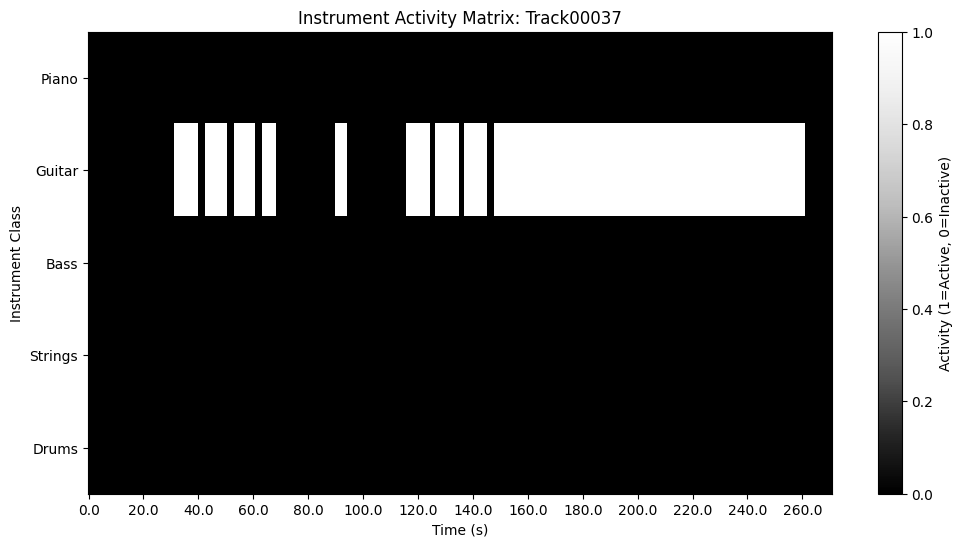

In [ ]:
# Define instrument labels for visualization
INSTRUMENT_LABELS = ["Piano", "Guitar", "Bass", "Strings", "Drums"]
MATRIX_PATH = "labels_isolated/"

# Visualize Example
example_file = sorted(os.listdir(MATRIX_PATH))[1]  
matrix = np.load(os.path.join(MATRIX_PATH, example_file))

plt.figure(figsize=(12, 6))
plt.imshow(matrix, aspect="auto", cmap="Greys_r", interpolation="nearest")

# Labels and title
plt.yticks(range(5), INSTRUMENT_LABELS)
plt.xticks(range(0, matrix.shape[1], 40), np.arange(0, matrix.shape[1] * 0.5, 20)) 
plt.xlabel("Time (s)")
plt.ylabel("Instrument Class")
plt.title(f"Instrument Activity Matrix: {example_file[:-4]}")
plt.colorbar(label="Activity (1=Active, 0=Inactive)")
plt.show()